In [1]:
import os

import cellprofiler.image
import cellprofiler.measurement
import cellprofiler.object
import cellprofiler.pipeline
import cellprofiler.preferences
import cellprofiler.workspace
import numpy as np
import pandas as pd
import skimage.io

/usr/local/miniconda3/envs/cellprofiler-notebooks/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def run_pipeline(pipeline_filename, image_dict):
    cellprofiler.preferences.set_headless()
    
    # Create and load the pipeline
    pipeline = cellprofiler.pipeline.Pipeline()
    pipeline.load(pipeline_filename)
    
    # Create the image set, and add the image data
    image_set_list = cellprofiler.image.ImageSetList()
    image_set = image_set_list.get_image_set(0)
    for image_name, input_pixels in image_dict.iteritems():
        image_set.add(image_name, cellprofiler.image.Image(input_pixels))
        
    # Persist the object set here (for now, see workspace TODO)
    object_set = cellprofiler.object.ObjectSet()

    # We can only run one group -- set the group index to 1.
    measurements = cellprofiler.measurement.Measurements()
    measurements.group_index = 1

    # Run the modules!
    for module in pipeline.modules():
        # Yes, we really do have to create a new workspace for each module
        # because the module attribute is required. Go team.
        workspace = cellprofiler.workspace.Workspace(
            image_set=image_set,
            image_set_list=image_set_list,
            measurements=measurements, 
            module=module,
            object_set=object_set, 
            pipeline=pipeline
        )
        
        module.prepare_run(workspace)
        module.run(workspace)
        module.post_run(workspace)
    
    # The workspace object has access to the measurements
    # and the image set/image set list which can be used
    # to use/view/store/whatever output data.
    return workspace

In [3]:
def objects2df(measurements, objects_name):
    features = measurements.get_feature_names(objects_name)
    
    n_features = len(features)
    n_objects = int(measurements.get_measurement("Image", "Count_{}".format(objects_name)))
    
    data = np.empty((n_objects, n_features))
    
    for feature_idx, feature in enumerate(features):
        data[:, feature_idx] = measurements.get_measurement(objects_name, feature)
    
    return pd.DataFrame(
        data=data,
        index=np.arange(1, n_objects + 1),
        columns=features
    )

In [4]:
# This should match what NamesAndTypes would produce.
images = {
    "OrigBlue": skimage.io.imread("data/images/01_POS002_D.TIF"),
    "OrigGreen": skimage.io.imread("data/images/01_POS002_F.TIF"),
    "OrigRed": skimage.io.imread("data/images/01_POS002_R.TIF")
}

pipeline_filename = "data/ExampleFly.cppipe"

In [5]:
workspace = run_pipeline(pipeline_filename, images)

No handlers could be found for logger "cellprofiler.modules.exporttodatabase"
/usr/local/miniconda3/envs/cellprofiler-notebooks/lib/python2.7/site-packages/cellprofiler/utilities/hdf5_dict.py:527: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  np.issubdtype(hdf5_type, int) or
/usr/local/miniconda3/envs/cellprofiler-notebooks/lib/python2.7/site-packages/cellprofiler/utilities/hdf5_dict.py:529: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  hdf5_type_is_float = np.issubdtype(hdf5_type, float)
/usr/local/miniconda3/envs/cellprofiler-notebooks/lib/python2.7/site-packages/centrosome/otsu.py:149: RuntimeWarning: invalid value encountered in divide
  mean = (cs[j] - cs[i]) / diff
/usr/local/miniconda3/envs/cellprofiler-notebooks/l

In [6]:
# Get the "Nuclei" object measurements, as a pandas DataFrame
df = objects2df(workspace.measurements, "Nuclei")
df.head()

,AreaShape_Area,AreaShape_Center_X,AreaShape_Center_Y,AreaShape_Center_Z,AreaShape_Compactness,AreaShape_Eccentricity,AreaShape_EulerNumber,AreaShape_Extent,AreaShape_FormFactor,AreaShape_MajorAxisLength,...,Texture_SumEntropy_CropBlue_3_02,Texture_SumEntropy_CropBlue_3_03,Texture_SumVariance_CropBlue_3_00,Texture_SumVariance_CropBlue_3_01,Texture_SumVariance_CropBlue_3_02,Texture_SumVariance_CropBlue_3_03,Texture_Variance_CropBlue_3_00,Texture_Variance_CropBlue_3_01,Texture_Variance_CropBlue_3_02,Texture_Variance_CropBlue_3_03
1,360.0,133.0,28.0,1.0,1.112285,0.756076,1.0,0.784314,0.805622,26.761739,...,6.354523,6.308452,724.563924,477.410947,598.249896,612.675279,211.659589,215.454660,210.159449,210.577060
2,325.0,87.0,48.0,1.0,1.088447,0.715051,1.0,0.706522,0.802242,24.645580,...,6.466266,6.473102,789.370104,470.203640,805.744251,844.428515,292.672293,301.859734,294.513421,291.769730
3,188.0,26.0,45.0,1.0,1.040556,0.645978,1.0,0.734375,0.870079,17.802596,...,5.532754,5.534234,218.652857,142.866497,247.581829,226.730610,94.784643,98.731975,94.219401,86.947920
4,320.0,14.0,66.0,1.0,1.007676,0.361018,1.0,0.800000,0.908718,21.002533,...,6.097452,6.000090,551.235507,394.865385,572.957751,449.026293,210.948724,221.452457,220.825976,207.832331
5,201.0,41.0,71.0,1.0,1.082705,0.718680,1.0,0.705263,0.758830,19.387906,...,5.661191,5.601019,285.654016,231.587456,310.802956,250.455748,116.600148,122.262864,108.214980,117.167641


/usr/local/miniconda3/envs/cellprofiler-notebooks/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


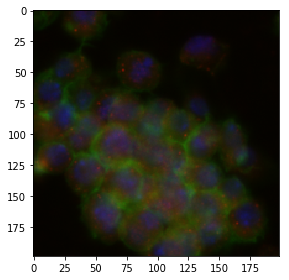

In [7]:
# Display the "RGBImage" image, created by GrayToColor
rgb_image = workspace.image_set.get_image("RGBImage")
skimage.io.imshow(rgb_image.pixel_data)